# SaaS Customer Churn Prediction and Renewal Analysis
- The goal of this project is underdstand customer churn patterns and predict renewals for a SaaS company using historical data.

### Generate Data
- The below is simulating the customer info from SaaS Company A

In [204]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PowerTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import sklearn.model_selection as train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay


np.random.seed(42)

number_samples = 5000

# Lists to generate categorical features
industry = ['Automotive', 'Finance', 'Healthcare', 'Retail', 'Technology', 'Government', 'Education', 'Manufacturing', 'Food and Beverage', 'Energy']
weighted_industry = np.random.rand(10)
weighted_industry = weighted_industry / weighted_industry.sum()
feature_use = ['low', 'medium', 'high']

# Helper function to generate random business dates
def random_dates(start, end, n):
    business_days = pd.date_range(start=start, end=end, freq='B')
    return np.random.choice(business_days, size=n, replace=True)

# Example usage
random_dates(pd.to_datetime('2015-01-01'), pd.to_datetime('2023-01-01'), 5)  # Example usage

array(['2021-06-17T00:00:00.000000000', '2017-12-13T00:00:00.000000000',
       '2020-10-22T00:00:00.000000000', '2019-08-29T00:00:00.000000000',
       '2018-08-30T00:00:00.000000000'], dtype='datetime64[ns]')

# Customer Data - Simulating data from a CRM system, this is 5000 sample of customers WW
- Customer ID: Unique ID given to customer in CRM

- Customer Size: Number of active full time employees that we use for licensing

- Annual Revenue: The latest reported revenue the customer reported based on sales intelligence softwate in the CRM 

- Industry: Customer industry

- C-Level Engagment: In B2B sales, how engaged we are to high level executives to get buy in for renewing contracts is critical, this is measuring how engaged they are from 'low' < 'medium' < 'high' based on email and meeting activity on the CRM

- Open Deals: Number of open opportunities tied to the customer account in the CRM

- Customer Sign Up Date: The day the customer officualy signed their contract

- Amount ARR Cloud: Annual Reoccuring Revenue coming from the customer payment for our SaaS service 

- Amount ARR On Prem: Annual Reoccuring Revenue coming from the customer payment for our on premises services

- Feature 1 Usage: From a scale 'low' < 'medium' < 'high' - how much the customer is leveraging Feature 1

- Feature 2 Usage: From a scale 'low' < 'medium' < 'high' - how much the customer is leveraging Feature 2

- Feature 3 Usage: From a scale 'low' < 'medium' < 'high' - how much the customer is leveraging Feature 3

- Churned: '0' indicates the customer is still active, '1' did not renew their contract

In [205]:
customer_data = {
    'customer_id': np.arange(1, number_samples + 1),
    'customer_size': np.random.normal(1500,250, number_samples).astype(int),
    'annual_revenue': np.random.normal(1000000, 200000, number_samples).round(2),
    'industry': np.random.choice(industry, number_samples, p=weighted_industry),
    'c_level_engagement': np.random.choice(feature_use, number_samples, p=[0.6, 0.2, 0.2]),
    'open_deals': np.random.binomial(1, 0.2, number_samples),
    'customer_sign_up_date': random_dates(pd.to_datetime('2010-01-01'), pd.to_datetime('2022-12-31'), number_samples),
    'amount_ARR_cloud': np.random.lognormal(12, 0.52, number_samples).round(2),
    'amount_ARR_on_prem': np.random.lognormal(9, 0.3, number_samples).round(2),
    'feature_1_usage': np.random.choice(feature_use, number_samples, p=[0.5, 0.3, 0.2]),
    'feature_2_usage': np.random.choice(feature_use, number_samples, p=[0.4, 0.4, 0.2]),
    'feature_3_usage': np.random.choice(feature_use, number_samples, p=[0.3, 0.5, 0.2]),
    'churned': np.random.binomial(1, 0.17, number_samples)
}

# Additional Features to Contruct
- Next Renewal Data: The date the contract expires

- Last QBR Date: The last date the account team held a Quaterly Business Review witht the customer executives

- Amount ARR Total: Sum of ARR Cloud and ARR On premises, total customer spend

- Customer Age: Number of Months the account has been an active customer

- Days between Renewal and QBR: Number of days between the last QBR date and the date the contract expires 

In [206]:
# Translate the customer data into a DataFrame and create additional features
df_customers = pd.DataFrame(customer_data)
df_customers['next_renewal_date'] = df_customers['customer_sign_up_date'] + pd.DateOffset(years=3)
df_customers['last_qbr_date'] = df_customers.apply(lambda df: random_dates(df['customer_sign_up_date'], 
                                                            df['next_renewal_date'], 1)[0], 
                                                            axis=1)
df_customers['amount_ARR_total'] = df_customers['amount_ARR_cloud'] + df_customers['amount_ARR_on_prem']
df_customers['customer_age'] = (pd.Timestamp.now() - df_customers['customer_sign_up_date']).dt.days // 30
df_customers['days_between_renewal_and_qbr'] = (df_customers['next_renewal_date'] - df_customers['last_qbr_date']).dt.days
df_customers.head()

,customer_id,customer_size,annual_revenue,industry,c_level_engagement,open_deals,customer_sign_up_date,amount_ARR_cloud,amount_ARR_on_prem,feature_1_usage,feature_2_usage,feature_3_usage,churned,next_renewal_date,last_qbr_date,amount_ARR_total,customer_age,days_between_renewal_and_qbr
0,1,1357,1008556.58,Finance,high,0,2021-02-10,204185.47,6982.61,medium,high,low,0,2024-02-10,2021-09-23,211168.08,58,870
1,2,1268,1098836.04,Energy,low,0,2016-09-30,110100.53,7266.24,low,medium,high,0,2019-09-30,2019-06-14,117366.77,111,108
2,3,846,1133341.21,Finance,low,0,2011-12-09,135663.57,7431.60,medium,medium,medium,0,2014-12-09,2014-08-22,143095.17,170,109
3,4,1737,987476.84,Finance,high,1,2017-07-17,222803.19,6652.80,medium,low,medium,0,2020-07-17,2019-12-31,229455.99,101,199
4,5,1704,905163.79,Food and Beverage,low,0,2010-09-14,217185.20,12329.89,high,low,high,0,2013-09-14,2011-09-30,229515.09,185,715


In [207]:
# Reviewing date features
df_customers[['customer_sign_up_date','next_renewal_date','last_qbr_date','days_between_renewal_and_qbr']].head()

,customer_sign_up_date,next_renewal_date,last_qbr_date,days_between_renewal_and_qbr
0,2021-02-10,2024-02-10,2021-09-23,870
1,2016-09-30,2019-09-30,2019-06-14,108
2,2011-12-09,2014-12-09,2014-08-22,109
3,2017-07-17,2020-07-17,2019-12-31,199
4,2010-09-14,2013-09-14,2011-09-30,715


# EDA
- Before builing a model, anaylizing the dataset above for nulls, duplicates, data cleaning, understading distribuions, and relationships among features

In [208]:
# Quick glance at number of nulls and data types
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   customer_id                   5000 non-null   int32         
 1   customer_size                 5000 non-null   int32         
 2   annual_revenue                5000 non-null   float64       
 3   industry                      5000 non-null   object        
 4   c_level_engagement            5000 non-null   object        
 5   open_deals                    5000 non-null   int32         
 6   customer_sign_up_date         5000 non-null   datetime64[ns]
 7   amount_ARR_cloud              5000 non-null   float64       
 8   amount_ARR_on_prem            5000 non-null   float64       
 9   feature_1_usage               5000 non-null   object        
 10  feature_2_usage               5000 non-null   object        
 11  feature_3_usage               

In [209]:
# Summary statistics of numerical features
df_customers.describe()

,customer_id,customer_size,annual_revenue,open_deals,customer_sign_up_date,amount_ARR_cloud,amount_ARR_on_prem,churned,next_renewal_date,last_qbr_date,amount_ARR_total,customer_age,days_between_renewal_and_qbr
count,5000.000000,5000.000000,5.000000e+03,5000.000000,5000,5.000000e+03,5000.000000,5000.000000,5000,5000,5.000000e+03,5000.000000,5000.000000
mean,2500.500000,1498.682400,9.959072e+05,0.191000,2016-07-06 19:55:12,1.847705e+05,8484.012946,0.173800,2019-07-07 14:47:19.680000,2018-01-07 12:50:06.720000,1.932545e+05,113.932400,546.081400
min,1.000000,629.000000,2.835875e+05,0.000000,2010-01-01 00:00:00,2.643850e+04,2122.430000,0.000000,2013-01-01 00:00:00,2010-03-04 00:00:00,3.482068e+04,35.000000,0.000000
25%,1250.750000,1330.750000,8.596250e+05,0.000000,2013-04-26 00:00:00,1.130612e+05,6592.890000,0.000000,2016-04-26 00:00:00,2014-10-02 00:00:00,1.215015e+05,74.000000,271.750000
50%,2500.500000,1498.000000,9.957253e+05,0.000000,2016-07-25 00:00:00,1.626816e+05,8074.080000,0.000000,2019-07-25 00:00:00,2018-01-03 00:00:00,1.709775e+05,113.000000,545.000000
75%,3750.250000,1669.000000,1.133897e+06,0.000000,2019-10-07 00:00:00,2.290364e+05,9983.867500,0.000000,2022-10-07 00:00:00,2021-03-31 06:00:00,2.379338e+05,153.000000,818.000000
max,5000.000000,2343.000000,1.708813e+06,1.000000,2022-12-30 00:00:00,1.109749e+06,24793.830000,1.000000,2025-12-30 00:00:00,2025-10-27 00:00:00,1.118157e+06,193.000000,1096.000000
std,1443.520003,246.976456,2.040639e+05,0.393128,NaN,1.020004e+05,2662.783888,0.378975,NaN,NaN,1.020205e+05,45.859037,316.996684


In [210]:
# Converting categorical features to ordered categorical types
categorical_features = ['c_level_engagement', 'feature_1_usage', 'feature_2_usage', 'feature_3_usage']

for col in categorical_features:
    df_customers[col] = pd.Categorical(df_customers[col], categories= feature_use, ordered=True)
    # Display the mean encoded value for each categorical feature
    print(f'{col}: {round(df_customers[col].cat.codes.mean(), 2)}')



c_level_engagement: 0.63
feature_1_usage: 0.69
feature_2_usage: 0.8
feature_3_usage: 0.91


In [211]:
# Checking for duplicate entries
df_customers.duplicated().sum()

0

In [212]:
# Identifying and Partitioning feature types in the DataFrame

# Numeric columns (int, float, nullable types)
numeric_features = df_customers.select_dtypes(include=['int64', 'float64']).columns.to_list()

# Categorical columns that are explicitly dtype "category"
categorical_features = df_customers.select_dtypes(include=['category']).columns.tolist()

# Nominal (object) features — typical object columns
nominal_categorical_features = df_customers.select_dtypes(include=['object']).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)
print("Nominal categorical features:", nominal_categorical_features)

Numeric features: ['annual_revenue', 'amount_ARR_cloud', 'amount_ARR_on_prem', 'amount_ARR_total', 'customer_age', 'days_between_renewal_and_qbr']
Categorical features: ['c_level_engagement', 'feature_1_usage', 'feature_2_usage', 'feature_3_usage']
Nominal categorical features: ['industry']


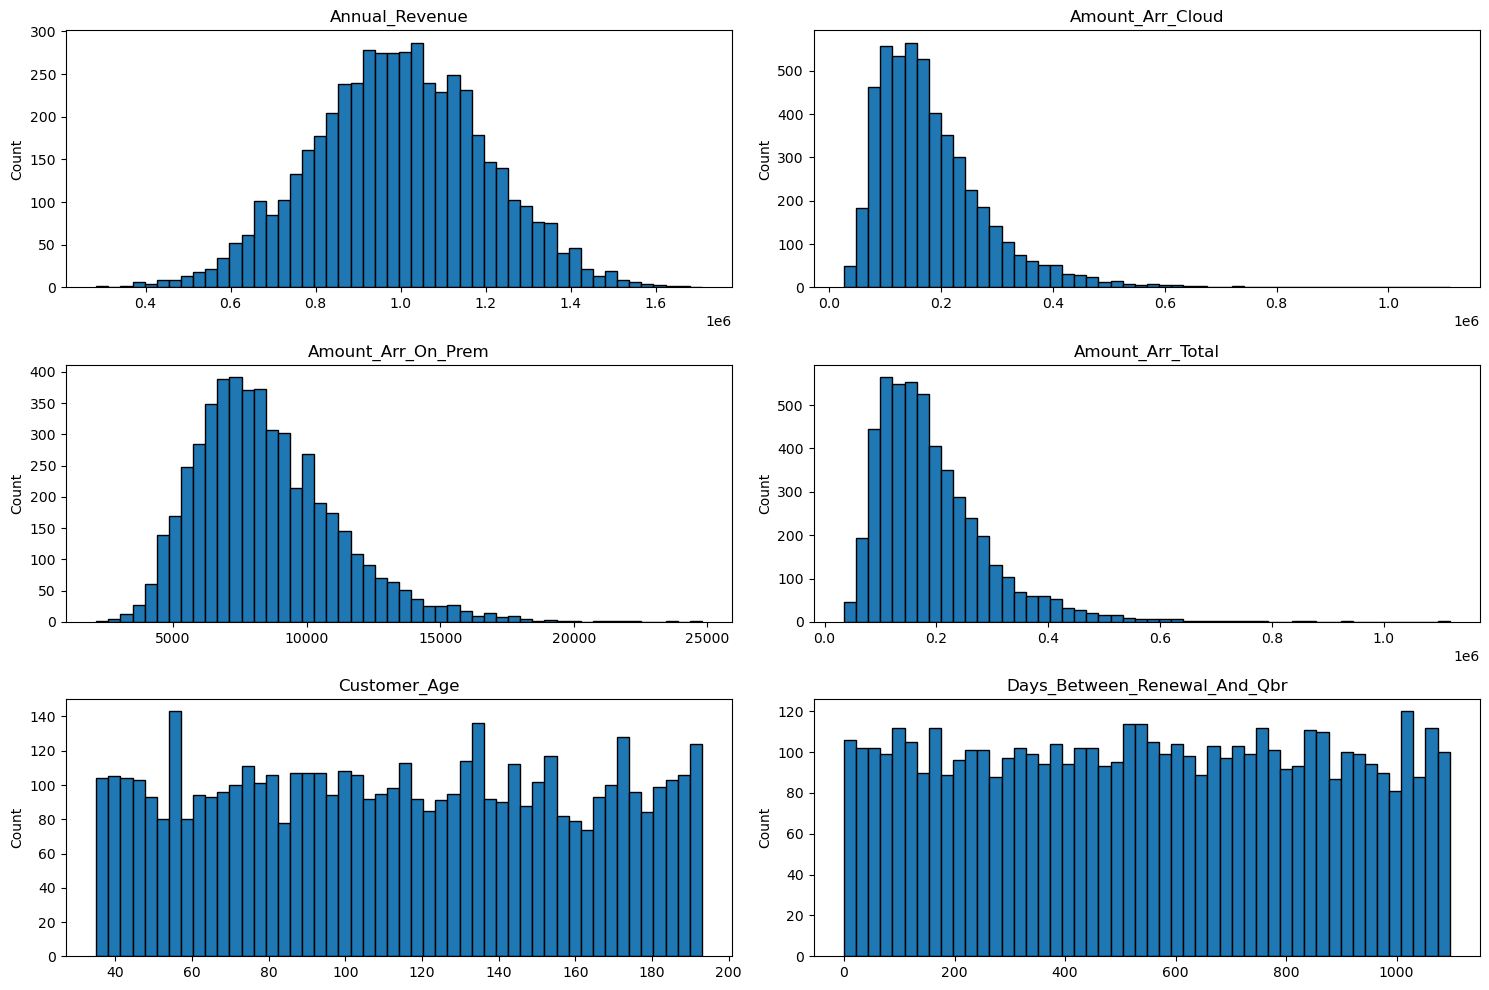

In [213]:
# Visualizing distributions of numerical features

ax = df_customers[numeric_features].hist(figsize=(15, 10), bins=50, edgecolor='black', grid=False)

# Make titles cleaner + adjust layout
for row in ax:
    for subplot in row:
        subplot.set_title(subplot.get_title().title())
        subplot.set_xlabel(subplot.get_xlabel().replace('_', ' ').title())
        subplot.set_ylabel("Count")

plt.tight_layout()
plt.show()

# Key takeaways:
- Annual Revenue is normally distributed
- ARR features have a right skew, important to transform these features prior to model fitting

Text(0.5, 1.0, 'Correlation Matrix for Numeric Features')

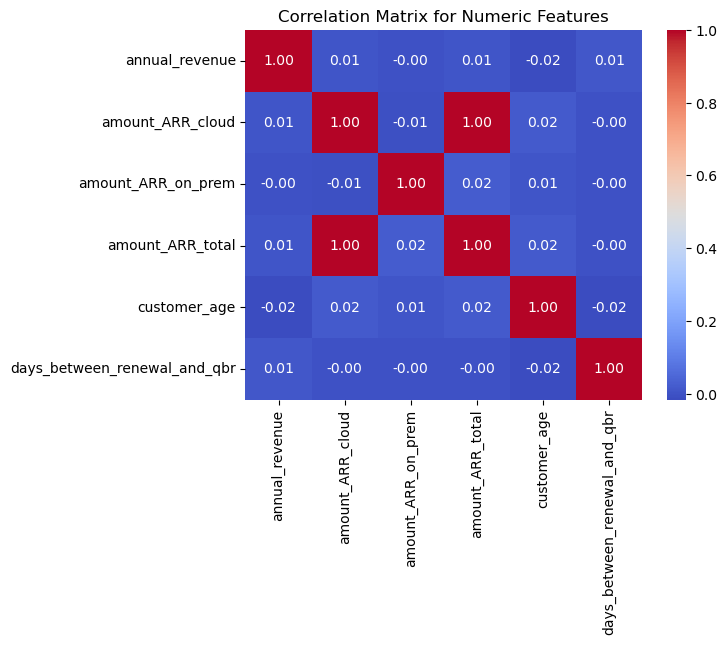

In [214]:
#  Correlation matrix for numeric features
df_customers[numeric_features].corr()
sns.heatmap(df_customers[numeric_features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix for Numeric Features')

# Key Take Aways
- Since ARR total depends of two other features, we do not need it as part of model fitting
- No other pair of features are highly correlated

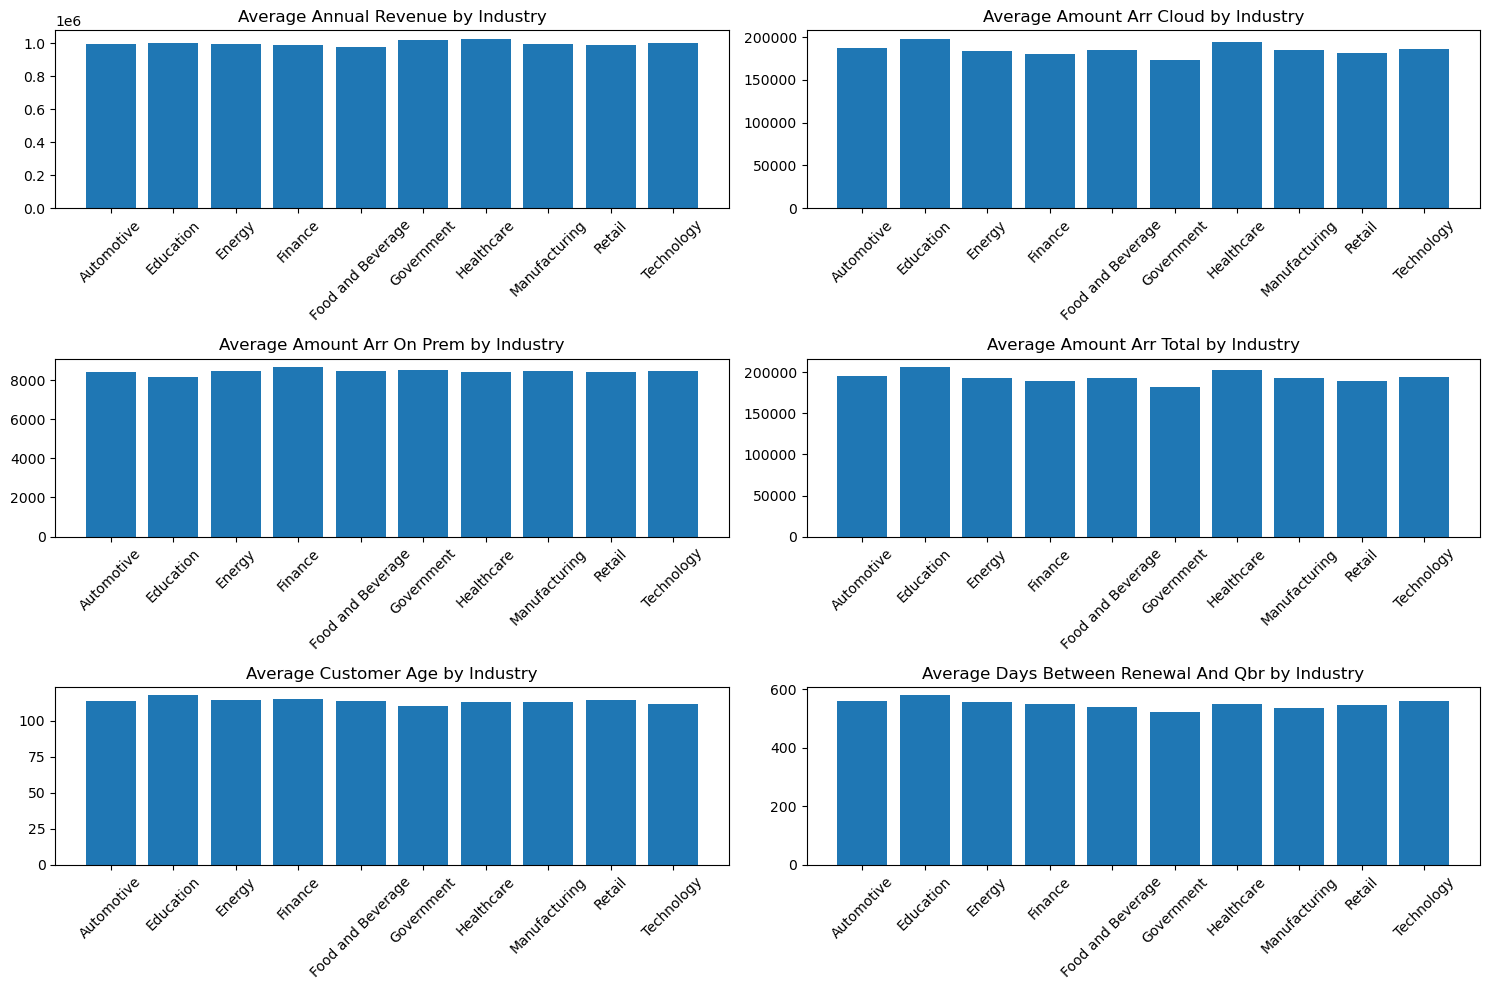

In [215]:
# Average numerical feature values by industry
fig, ax = plt.subplots(3, 2, figsize=(15, 10))

all_axes = ax.flatten()

for num_feat, subplot in zip(numeric_features, all_axes):

    industry_group = df_customers.groupby('industry')[num_feat].mean()

    subplot.bar(x=industry_group.index, height=industry_group.values)
    
    subplot.set_title(f'Average {num_feat.replace("_", " ").title()} by Industry')
    subplot.tick_params(axis='x', rotation=45) # Rotate X-labels
    plt.tight_layout()

In [216]:
# Churn rate by industry
pd.crosstab(df_customers['industry'], df_customers['churned'], normalize='index')

churned,0,1
industry,,
Automotive,0.833780,0.166220
Education,0.816327,0.183673
Energy,0.843165,0.156835
Finance,0.797539,0.202461
Food and Beverage,0.827645,0.172355
Government,0.856322,0.143678
Healthcare,0.827688,0.172312
Manufacturing,0.814677,0.185323
Retail,0.844948,0.155052


In [217]:
# Looking at churn rates for the the sample
df_customers['churned'].value_counts(normalize=True)

churned
0    0.8262
1    0.1738
Name: proportion, dtype: float64

# Preprocessing + Feature Engineering
- Before creating and fitting the model, we are going to preprocess and perform feature engineering
- First we will remoce Amount ARR total since it is not an independent feature
- Will define our features (X) and our target variable (y)
- Since our ARR feature have a right skew, we use Power Transformer (take the log of numbers) to ensure we have a normal distribution
- Then we will map the appropiate processing to each data type
- Numerical features will be transformed by Standard Scaler to ensure they have center and std
- Nominal features will be transformed by OneHotEncoding 
- Categorical features will be transfomed by OrdinalEncoder to preserve ranking
- We will remove any features with low variance
- Lastly, we split our data to traning and testing splits/


In [218]:
#Remove highly correlated feature
list(numeric_features).remove('amount_ARR_total')

# Combining all feature types for modeling
features = list(numeric_features) + list(categorical_features) + list(nominal_categorical_features)

# Define feature matrix X and target variable y
X = df_customers[features]
y = df_customers['churned']

X_train, X_test, y_train, y_test = train_test_split.train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [238]:
# Defining preprocessing steps with ColumnTransformer
power_features = ['amount_ARR_cloud','amount_ARR_on_prem']
num_remaining = [feature for feature in numeric_features if feature not in power_features]

preprocessor = ColumnTransformer(
    transformers=[
        ('power', Pipeline([('power', PowerTransformer()), ('scale', StandardScaler())]), power_features),
        ('num_scale', StandardScaler(), num_remaining),
        ('cat_ord', OrdinalEncoder(), categorical_features),
        ('nom_ohe', OneHotEncoder(drop='first'), nominal_categorical_features)
    ])

full_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('variance_threshold', VarianceThreshold(threshold=0.01))])


# Building + Evaluating the Model
- We will use a Logistic Regression model, and we will search for the ideal hyperparameters using Randomized Search.

- We will test for both L1 and L2 regression and how strong the regularization should be by C

In [241]:
# Hyperparameters Tuning to optimize Logistic Regression model
params = {'penalty': ['l1', 'l2'], 'C': np.logspace(-10, 10, 10)}

log_classifier = LogisticRegression(solver='liblinear', class_weight='balanced')

log_classifier_tuned = GridSearchCV(estimator=log_classifier, param_grid=params, cv=5, scoring='f1')

In [242]:
# Fit the model with the training data + Look at best parameters
X_train_transformed = full_pipeline.fit_transform(X_train)
X_test_transformed = full_pipeline.transform(X_test)

log_classifier_tuned.fit(X_train_transformed, y_train)

log_classifier_tuned.best_params_

{'C': 2.782559402207126e-06, 'penalty': 'l2'}

In [244]:
# Evaluate the best model on the test set
best_model = log_classifier_tuned.best_estimator_

#print("Cross-Validation Score:", cross_val_score(best_model, X_reduced, y, cv=5).mean())
print("Training F1 Score:", best_model.score(X_train_transformed, y_train))
print("Test F1 Score:", best_model.score(X_test_transformed, y_test))

Training F1 Score: 0.3835
Test F1 Score: 0.361


In [245]:
y_pred = best_model.predict(X_test_transformed)
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.29      0.43       826
           1       0.17      0.71      0.28       174

    accuracy                           0.36      1000
   macro avg       0.50      0.50      0.35      1000
weighted avg       0.71      0.36      0.40      1000

Confusion Matrix:
 [[237 589]
 [ 50 124]]


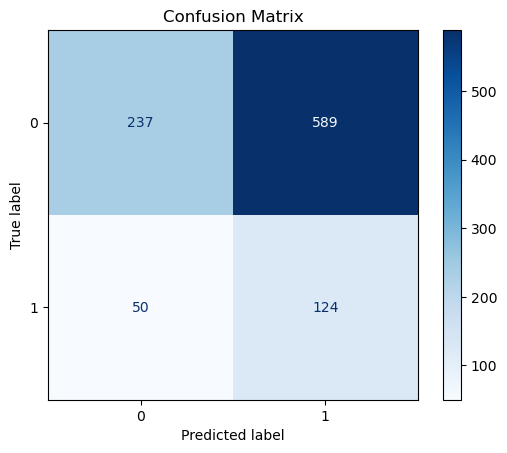

In [246]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))

# Plot the matrix
disp.plot(cmap=plt.cm.Blues) # cmap sets the color scheme (e.g., 'viridis', 'Reds')
plt.title("Confusion Matrix")
plt.show()

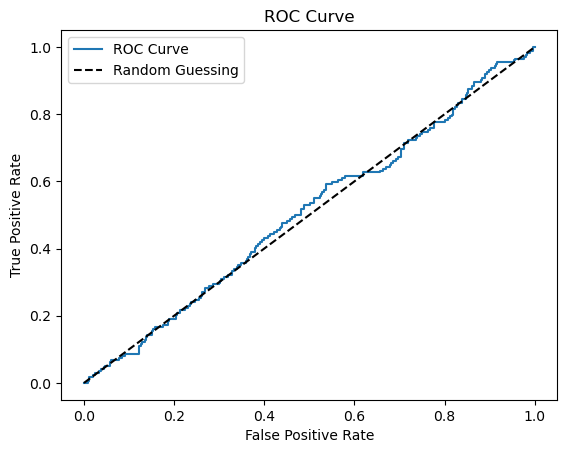

In [247]:
roc_curves = roc_curve(y_test, best_model.predict_proba(X_test_transformed)[:, 1])
plt.plot(roc_curves[0], roc_curves[1], label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()